In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [298]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"
# enrichment_file = "enrichr"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Actually, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

elif enrichment_file == "enrichr": # Get enrichr results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichr.csv", index_col=0)
    enr.rename(columns={"path_name": "native", "adj_p_val": "p_value"}, inplace=True)

enr["name"] = enr["native"]

In [299]:
idx_MF = enr["source"] == "GO_Molecular_Function_2021" # Molecular function
idx_CC = enr["source"] == "GO_Cellular_Component_2021" # Cellular component
idx_BP = enr["source"] == "GO_Biological_Process_2021" # Biological process
idx_KEGG = enr["source"] == "KEGG_2021_Human" # KEGG pathways
idx_Reac = enr["source"] == "Reactome_2016" # Reactome pathways
idx_Marker = enr["source"] == "CellMarker_Augmented_2021" # Cell types

In [300]:
enr = enr[enr["p_value"] < .05]

In [301]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [302]:
enr.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
0,CellMarker_Augmented_2021,Monocyte:Fetal Kidney,Monocyte:Fetal Kidney,2.004081e-49,True,NaN,797,175,79,14167,0.451429,0.099122,bottom_mofa 2,[],mofa,2,48.698085
1,CellMarker_Augmented_2021,B cell:Kidney,B cell:Kidney,5.488459e-36,True,NaN,668,166,61,14167,0.367470,0.091317,bottom_mofa 1,[],mofa,1,35.260550
2,CellMarker_Augmented_2021,Mucosal-associated Invariant T cell:Liver,Mucosal-associated Invariant T cell:Liver,2.210989e-23,True,NaN,68,171,22,14167,0.128655,0.323529,bottom_mofa 9,[],mofa,9,22.655413
3,CellMarker_Augmented_2021,CD1C-CD141- Dendritic cell:Blood,CD1C-CD141- Dendritic cell:Blood,1.021845e-22,True,NaN,314,169,36,14167,0.213018,0.114650,bottom_mofa 8,[],mofa,8,21.990615
4,CellMarker_Augmented_2021,Paneth cell:Large Intestine,Paneth cell:Large Intestine,4.697005e-20,True,NaN,311,175,34,14167,0.194286,0.109325,bottom_mofa 2,[],mofa,2,19.328179


## Is Mowgli more specific?

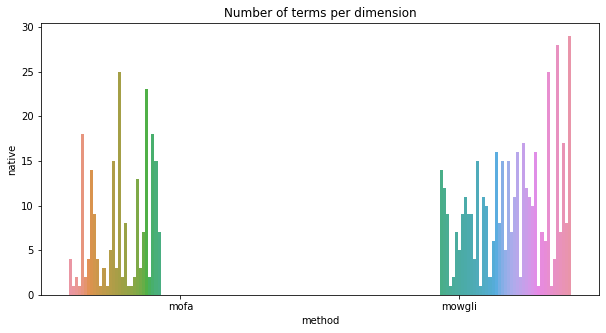

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = enr.loc[idx_BP].groupby(["method", "query"])["native"].nunique().reset_index()
sns.barplot(
    data=df,
    x="method",
    y="native",
    hue="query",
    ax=ax,
)
ax.set_title("Number of terms per dimension")
ax.get_legend().remove()
plt.show()
# + and - counted separately or mofa


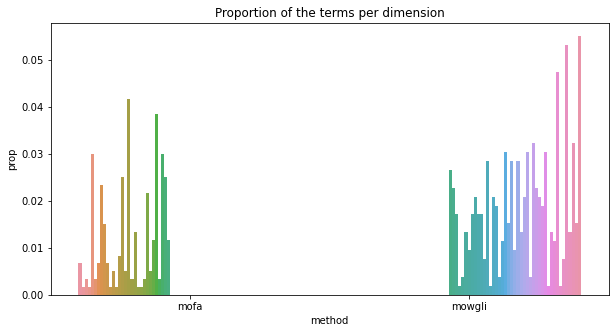

In [304]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = enr.loc[idx_BP].groupby(["method", "query"])["native"].nunique().reset_index()
df["nterms"] = df["method"].map(enr.groupby("method")["native"].nunique())
df["prop"] = df["native"] / df["nterms"]
sns.barplot(
    data=df,
    x="method",
    y="prop",
    hue="query",
    ax=ax,
)
ax.set_title("Proportion of the terms per dimension")
ax.get_legend().remove()
plt.show()
# + and - counted separately or mofa

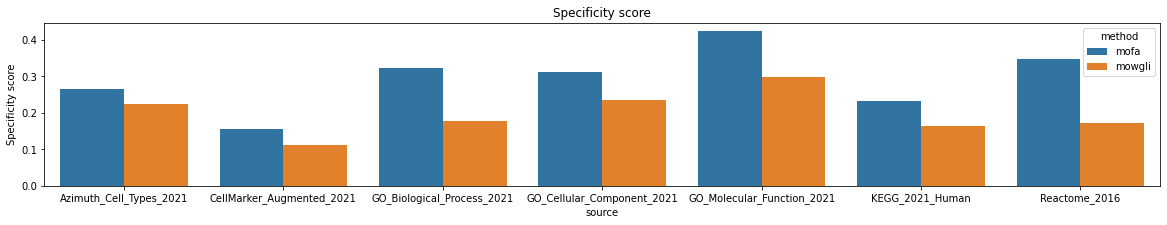

In [305]:
# specificity score
s = enr.groupby(["source", "method"])["native"].nunique()  # nterms
s += enr.groupby(["source", "method"])["query"].nunique()  # ndims
s /= 2 * enr.groupby(["source", "method"])["native"].count()  # 2*nlinks
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
sns.barplot(
    data=pd.DataFrame(s).reset_index(),
    x="source",
    hue="method",
    y="native",
    ax=ax,
)
ax.set_title("Specificity score")
ax.set_ylabel("Specificity score")
plt.show()


## Does Mowgli find other things?

In [306]:
mofa_terms = enr.loc[enr["method"] == "mofa"].groupby("source")["native"].unique()
mowgli_terms = enr.loc[enr["method"] == "mowgli"].groupby("source")["native"].unique()
intersecting_terms = {
    source: np.intersect1d(mofa_terms[source], mowgli_terms[source])
    for source in mofa_terms.index
}

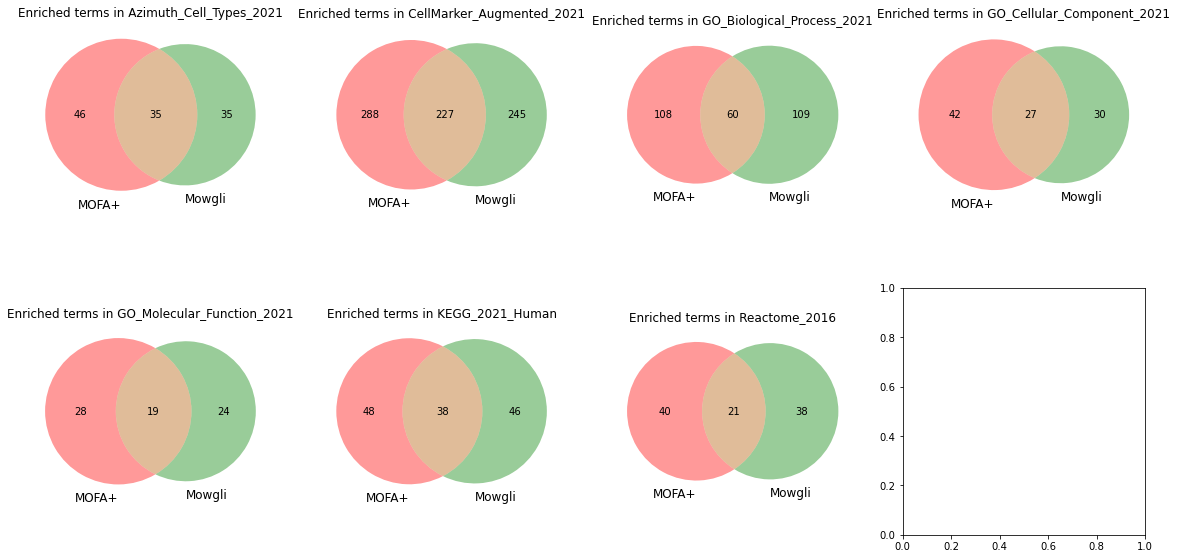

In [308]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, source in enumerate(mofa_terms.index):
    ax = axes[i // 4, i % 4]
    venn2(
        subsets=(
            len(mofa_terms[source]),
            len(mowgli_terms[source]),
            len(intersecting_terms[source]),
        ),
        set_labels=("MOFA+", "Mowgli"),
        ax=ax,
    )
    ax.set_title("Enriched terms in " + source)


<AxesSubplot:xlabel='term_size', ylabel='minlogp'>

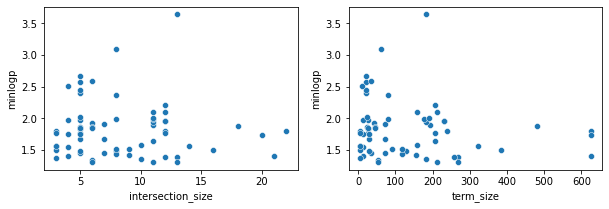

In [309]:
terms_in_mofa_only = np.setdiff1d(
    mofa_terms["GO_Biological_Process_2021"],
    mowgli_terms["GO_Biological_Process_2021"],
)
df = enr.set_index("native").loc[
    terms_in_mofa_only,
    ["minlogp", "term_size", "query_size", "intersection_size"],
].reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.scatterplot(data=df, x="intersection_size", y="minlogp", ax=axes[0])
sns.scatterplot(data=df, x="term_size", y="minlogp", ax=axes[1])

<AxesSubplot:xlabel='term_size', ylabel='minlogp'>

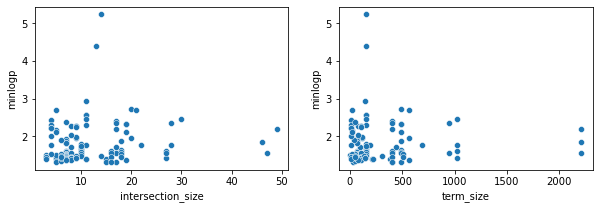

In [310]:
terms_in_mowgli_only = np.setdiff1d(
    mowgli_terms["GO_Biological_Process_2021"],
    mofa_terms["GO_Biological_Process_2021"],
)
df = enr.set_index("native").loc[
    terms_in_mowgli_only,
    ["minlogp", "term_size", "query_size", "intersection_size"],
].reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.scatterplot(data=df, x="intersection_size", y="minlogp", ax=axes[0])
sns.scatterplot(data=df, x="term_size", y="minlogp", ax=axes[1])

## Does Mowgli respect biology better?

In [311]:
import muon as mu
import anndata as ad
import mofax
import scanpy as sc

# Define the data folders.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
fig_folder = (
    "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/visualize/figures/"
)
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"


# Load the data.
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

# Load the MOFA model.
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
mdata.obsm["X_mofa"] = mofa_model.get_factors()

# Load the Mowgli model.
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]

# This is needed somehow.
mdata.uns = {}

# Make an object for the Mowgli embedding.
mowgli_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)
mowgli_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

# Make an object for the MOFA embedding.
mofa_embedding = ad.AnnData(mdata.obsm["X_mofa"], obs=mdata.obs)
mofa_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

In [312]:
# Compute neighbors for Mowgli and MOFA.
sc.pp.neighbors(mowgli_embedding, n_neighbors=25)
sc.pp.neighbors(mofa_embedding, n_neighbors=25)

# Compute Leiden for Mowgli and MOFA.
# The extra level of high resolution is useful to clean up the heatmap.
sc.tl.leiden(mowgli_embedding, resolution=0.2, key_added="leiden")
sc.tl.leiden(mofa_embedding, resolution=0.2, key_added="leiden")

# Annotate the MOFA emebdding.
cluster_names = {
    1: "B cells",
    8: "B cells",
    0: "CD4 T cells",
    2: "CD4 T cells",
    4: "CD8 T cells",
    6: "CD8 T cells",
    3: "Monocytes",
    5: "NK cells",
    7: "MAIT T cells",
    9: "Erythroid cells",
}
mofa_embedding.obs["leiden"] = [
    cluster_names[c] for c in mofa_embedding.obs["leiden"].cat.codes
]

# Annotate the Mowgli embedding.
cluster_names = {
    0: "B cells",
    1: "CD4 T cells",
    2: "CD4 T cells",
    3: "CD8 T cells",
    4: "CD4 T cells",
    5: "Monocytes",
    6: "NK cells",
    7: "MAIT T cells",
    8: "Erythroid cells",
}
mowgli_embedding.obs["leiden"] = [
    cluster_names[c] for c in mowgli_embedding.obs["leiden"].cat.codes
]

In [313]:
mowgli_embedding.obs["leiden"] = pd.Categorical(mowgli_embedding.obs["leiden"])
mofa_embedding.obs["leiden"] = pd.Categorical(mofa_embedding.obs["leiden"])

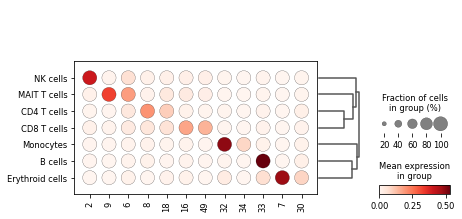

In [314]:
sc.tl.dendrogram(mowgli_embedding, groupby="leiden")
varnames = ["2", "9", "6", "8", "18", "16", "49", "32", "34", "33", "7", "30"]
# "0", "1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48",
sc.pl.dotplot(
    mowgli_embedding,
    varnames,
    groupby="leiden",
    dendrogram=True,
    expression_cutoff=-100,
)


In [323]:
celltypes = enr["native"][enr["source"].str.contains("Azimuth", regex=False)].unique()
# celltypes = enr["native"][enr["native"].str.contains(":Blood", regex=False)].unique()
# celltypes = enr["native"][enr["native"].str.contains(":Peripheral Blood", regex=False)].unique()

In [351]:
celltypes = [
    "Dendritic Cell CL0000451",
    "Natural Killer CL0000623",
    # "Natural Killer Cell CL0000623",
    # "Memory B Cell, Kappa Light Chain CL0000787",
    "B Cell CL0000785",
    # "B CL0000236",
    # "Naive B Cell, Kappa Light Chain CL0000788",
    # "Intermediate B Cell, Kappa Light Chain CL0000785",
    # "CD14+ Monocyte CL0002057",
    # "Classical Monocyte CL0000860",
    "Monocyte CL0000576",
    # "Myeloid Dendritic Type 2 CL0000782",
    # "EREG+ Dendritic CL0000451",
    # "CD8+ Naive T CL0000900",
    "CD4 T CL0000624",
    # "CD8+ Central Memory T 2 CL0000909",
    # "CD8+ Effector Memory T 4 CL0001050",
    # "CD8+ Central Memory T CL0000909",
    # "CD8+ Effector Memory T 3 CL0001050",
    # "Intermediate B Cell CL0000785",
    # "Intermediate B Cell, Lambda Light Chain CL0000785",
    # "CD8+ Effector Memory T CL0001050",
    # "OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL0000128",
    # "OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL0000128",
    # "Gamma-Delta T 3 CL0000798",
    # "CD16+ Monocyte CL0002396",
    # "CD56-dim Natural Killer CL0000939",
    "CD8 T CL0000625",
    # "CD56-dim Natural Killer 2 CL0000939",
    # "CD8+ Effector Memory T 5 CL0001050",
    # "CD56-dim Natural Killer 1 CL0000939",
    # "Memory B Cell CL0000787",
    # "Memory B Cell, Lambda Light Chain CL0000787",
    # "CD4+ Cytotoxic T CL0000934",
    "Mucosal Associated Invariant T CL0000940",
    # "CD8+ Effector Memory T 1 CL0001050",
    # "Conventional Dendritic Cell 2 2 CL0002399",
    # "Naive B Cell CL0000788",
    # "CD4+ Effector Memory T CL0001044",
    # "CD4+ Effector Memory T 1 CL0001044",
    # "CD56-dim Natural Killer 3 CL0000939",
    # "CD8+ Effector Memory T 2 CL0001050",
    # "CD8+ Effector Memory T 6 CL0001050",
    # "Other T Cell CL0002419",
    # "CD8+ Central Memory T 3 CL0000909",
    # "CD8+ Central Memory T 1 CL0000909",
]


In [352]:
mowgli_pvals = ad.AnnData(1e-3*np.random.rand(len(celltypes), mowgli_embedding.n_vars) + np.zeros((len(celltypes), mowgli_embedding.n_vars)))
mowgli_pvals.obs_names = celltypes
mowgli_pvals.var_names = mowgli_embedding.var_names

mowgli_pvals2 = ad.AnnData(1e-3*np.random.rand(len(celltypes), mowgli_embedding.n_vars) + np.zeros((len(celltypes), mowgli_embedding.n_vars)))
mowgli_pvals2.obs_names = celltypes
mowgli_pvals2.var_names = mowgli_embedding.var_names

mowgli_pvals = ad.concat((mowgli_pvals, mowgli_pvals2))

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["method"] == "mowgli"
    mowgli_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mowgli_pvals.obs["celltype"] = pd.Categorical(mowgli_pvals.obs_names)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


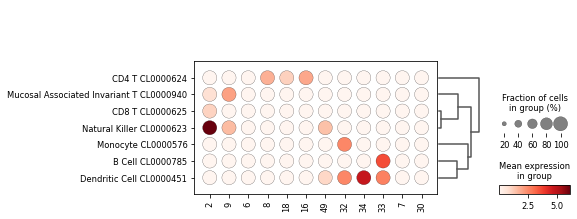

In [353]:
# varnames = mowgli_pvals.var_names[mowgli_pvals.X.max(0).argsort()[::-1][:50]]
varnames = ["2", "9", "6", "8", "18", "16", "49", "32", "34", "33", "7", "30"]
sc.tl.dendrogram(mowgli_pvals, groupby="celltype")
sc.pl.dotplot(mowgli_pvals, varnames, groupby="celltype", categories_order=celltypes, dendrogram=True)

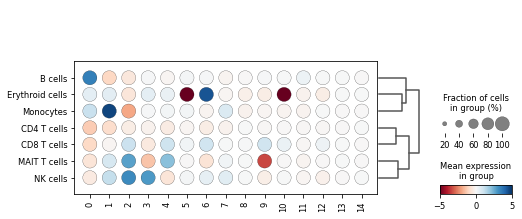

In [343]:
sc.tl.dendrogram(mofa_embedding, groupby="leiden")
sc.pl.dotplot(mofa_embedding, mofa_embedding.var_names, groupby="leiden", dendrogram=True, cmap="RdBu", vmin=-5, vmax=5, expression_cutoff=-100)

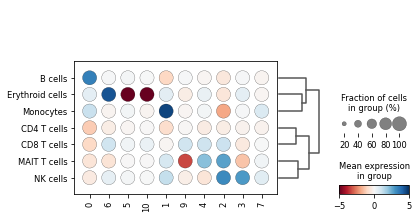

In [344]:
sc.tl.dendrogram(mofa_embedding, groupby="leiden")
idx = [0, 6, 5, 10, 1, 9, 4, 2, 3, 7]
sc.pl.dotplot(
    mofa_embedding,
    mofa_embedding.var_names[idx],
    groupby="leiden",
    dendrogram=True,
    cmap="RdBu",
    vmin=-5,
    vmax=5,
    expression_cutoff=-100,
)


In [345]:
mofa_pvals = ad.AnnData(1e-3*np.random.rand(len(celltypes), mofa_embedding.n_vars) + np.zeros((len(celltypes), mofa_embedding.n_vars)))
mofa_pvals.obs_names = celltypes
mofa_pvals.var_names = mofa_embedding.var_names

mofa_pvals2 = ad.AnnData(1e-3*np.random.rand(len(celltypes), mofa_embedding.n_vars) + np.zeros((len(celltypes), mofa_embedding.n_vars)))
mofa_pvals2.obs_names = celltypes
mofa_pvals2.var_names = mofa_embedding.var_names

mofa_pvals = ad.concat((mofa_pvals, mofa_pvals2))

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["query"].str.startswith("top_mofa")
    mofa_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]

    idx = enr["native"] == celltype
    idx &= enr["query"].str.startswith("bottom_mofa")
    mofa_pvals.X[i, enr.loc[idx, "dim"]] = -enr.loc[idx, "minlogp"]
mofa_pvals.obs["celltype"] = pd.Categorical(mofa_pvals.obs_names)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


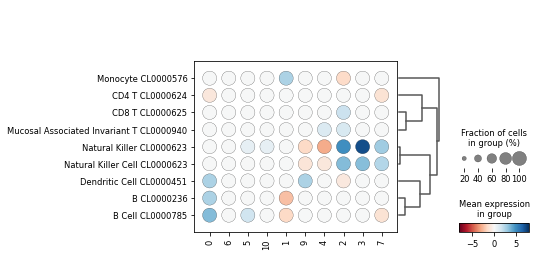

In [346]:
sc.tl.dendrogram(mofa_pvals, groupby="celltype")
idx = [0, 6, 5, 10, 1, 9, 4, 2, 3, 7]
sc.pl.dotplot(mofa_pvals, mofa_pvals.var_names[idx], groupby="celltype", expression_cutoff=-100, dendrogram=True, vmin=-8, vmax=8, cmap="RdBu")

## Count enrichments

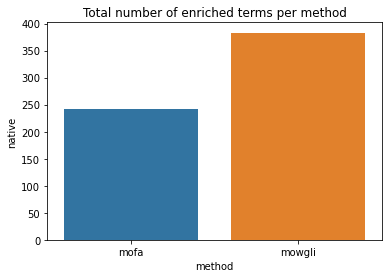

In [ ]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

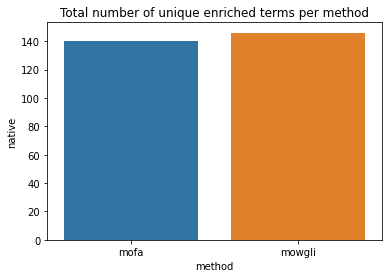

In [ ]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

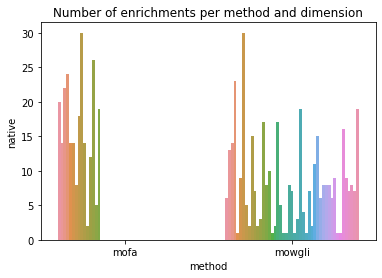

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

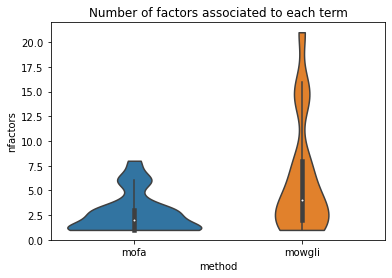

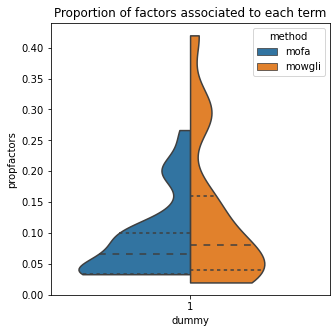

In [ ]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors", cut=0)
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 30
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(
    data=enr,
    x="dummy",
    hue="method",
    y="propfactors",
    split=True,
    ax=ax,
    inner="quart",
    cut=0,
)
plt.show()


In [ ]:
selectivity_mofa = (enr[enr["method"] == "mofa"]["native"].nunique() + 30) / (2*enr[enr["method"] == "mofa"]["native"].count())
selectivity_mowgli = (enr[enr["method"] == "mowgli"]["native"].nunique() + 50) / (2*enr[enr["method"] == "mowgli"]["native"].count())
print("Selectivity of MOFA+: {:.4f}".format(selectivity_mofa))
print("Selectivity of Mowgli: {:.4f}".format(selectivity_mowgli))

Selectivity of MOFA+: 0.3512
Selectivity of Mowgli: 0.2559


## Biology-driven check

In [ ]:
idx_mowgli = (enr["method"] == "mofa")
idx_mowgli = (enr["query"].str.startswith("top"))
idx_mowgli &= (enr["dim"] == 6)
enr[idx_mowgli].sort_values("p_value").head(10)

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
134,negative regulation of epithelial cell prolife...,mofa,GO_Biological_Process_2021,negative regulation of epithelial cell prolife...,0.000722,True,NaN,72,64,6,...,0.093750,0.083333,top_mofa 6,[],6,3.141317,3,30,0.100000,1
179,negative regulation of cell population prolife...,mofa,GO_Biological_Process_2021,negative regulation of cell population prolife...,0.009115,True,NaN,379,68,10,...,0.147059,0.026385,top_mofa 6,[],6,2.040224,3,30,0.100000,1
185,T cell activation (GO:0042110),mofa,GO_Biological_Process_2021,T cell activation (GO:0042110),0.011761,True,NaN,92,47,5,...,0.106383,0.054348,top_mofa 6,[],6,1.929547,1,30,0.033333,1
219,regulation of cell migration (GO:0030334),mofa,GO_Biological_Process_2021,regulation of cell migration (GO:0030334),0.037003,True,NaN,408,74,10,...,0.135135,0.024510,top_mofa 6,[],6,1.431759,8,30,0.266667,1
227,negative regulation of response to external st...,mofa,GO_Biological_Process_2021,negative regulation of response to external st...,0.040924,True,NaN,118,78,6,...,0.076923,0.050847,top_mofa 6,[],6,1.388018,2,30,0.066667,1
237,regulation of GTPase activity (GO:0043087),mofa,GO_Biological_Process_2021,regulation of GTPase activity (GO:0043087),0.048407,True,NaN,189,74,7,...,0.094595,0.037037,top_mofa 6,[],6,1.315091,1,30,0.033333,1
241,regulation of immune response (GO:0050776),mofa,GO_Biological_Process_2021,regulation of immune response (GO:0050776),0.049744,True,NaN,179,17,4,...,0.235294,0.022346,top_mofa 6,[],6,1.303262,3,30,0.100000,1


In [ ]:
idx_mofa = (enr["method"] == "mofa")
idx_mofa &= (enr["dim"] == 0)
idx_mowgli = (enr["method"] == "mowgli")
idx_mowgli &= (enr["dim"] == 33)
pd.concat((enr[idx_mofa].sort_values("p_value").head(10), enr[idx_mowgli].sort_values("p_value").head(10)))

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
115,regulation of B cell proliferation (GO:0030888),mofa,GO_Biological_Process_2021,regulation of B cell proliferation (GO:0030888),0.000018,True,NaN,46,56,6,...,0.107143,0.130435,top_mofa 0,[],0,4.738494,1,30,0.033333,1
116,antigen receptor-mediated signaling pathway (G...,mofa,GO_Biological_Process_2021,antigen receptor-mediated signaling pathway (G...,0.000019,True,NaN,185,72,10,...,0.138889,0.054054,top_mofa 0,[],0,4.719808,6,30,0.200000,1
119,B cell activation (GO:0042113),mofa,GO_Biological_Process_2021,B cell activation (GO:0042113),0.000206,True,NaN,85,74,7,...,0.094595,0.082353,top_mofa 0,[],0,3.685327,2,30,0.066667,1
136,interferon-gamma-mediated signaling pathway (G...,mofa,GO_Biological_Process_2021,interferon-gamma-mediated signaling pathway (G...,0.000770,True,NaN,68,70,6,...,0.085714,0.088235,top_mofa 0,[],0,3.113780,3,30,0.100000,1
140,regulation of B cell receptor signaling pathwa...,mofa,GO_Biological_Process_2021,regulation of B cell receptor signaling pathwa...,0.001544,True,NaN,23,56,4,...,0.071429,0.173913,top_mofa 0,[],0,2.811279,3,30,0.100000,1
22,"positive regulation of transcription, DNA-temp...",mofa,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",0.005153,True,NaN,1183,62,17,...,0.274194,0.014370,bottom_mofa 0,[],0,2.287957,6,30,0.200000,1
167,negative regulation of B cell activation (GO:0...,mofa,GO_Biological_Process_2021,negative regulation of B cell activation (GO:0...,0.006443,True,NaN,22,3,2,...,0.666667,0.090909,top_mofa 0,[],0,2.190925,3,30,0.100000,1
168,antigen processing and presentation of exogeno...,mofa,GO_Biological_Process_2021,antigen processing and presentation of exogeno...,0.006628,True,NaN,98,70,6,...,0.085714,0.061224,top_mofa 0,[],0,2.178618,1,30,0.033333,1
174,antigen processing and presentation of peptide...,mofa,GO_Biological_Process_2021,antigen processing and presentation of peptide...,0.007451,True,NaN,100,70,6,...,0.085714,0.060000,top_mofa 0,[],0,2.127784,1,30,0.033333,1
175,B cell receptor signaling pathway (GO:0050853),mofa,GO_Biological_Process_2021,B cell receptor signaling pathway (GO:0050853),0.007844,True,NaN,34,56,4,...,0.071429,0.117647,top_mofa 0,[],0,2.105482,1,30,0.033333,1


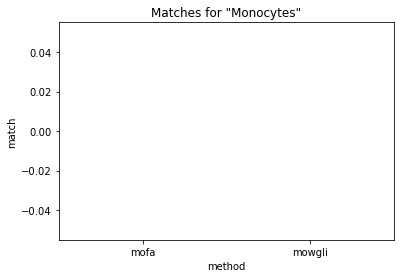

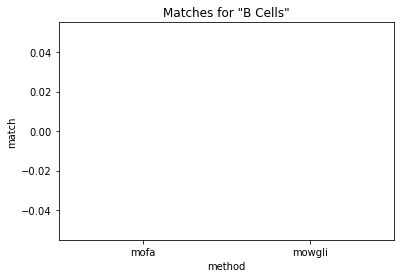

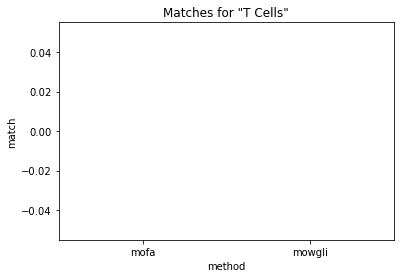

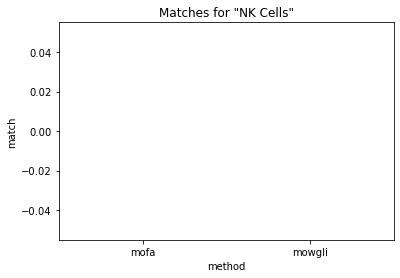

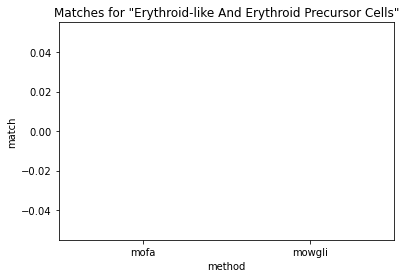

In [ ]:
# TODO: check this, it seems weird
def barplot_matches(keywords, case=False):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].sum().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()

for celltype in celltypes:
    try:
        barplot_matches(celltype)
    except:
        pass

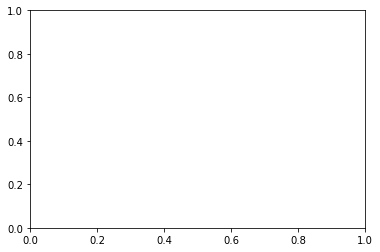

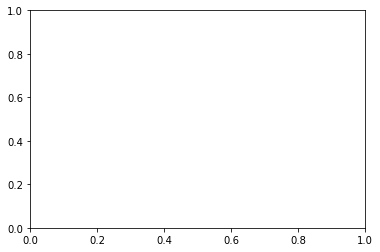

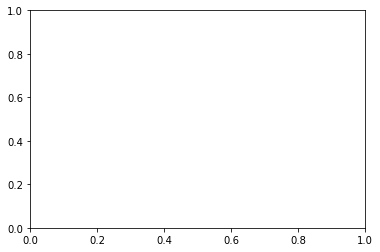

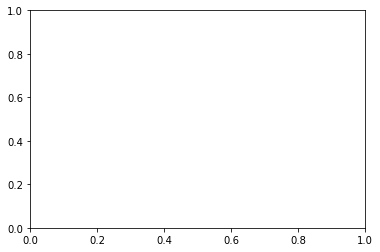

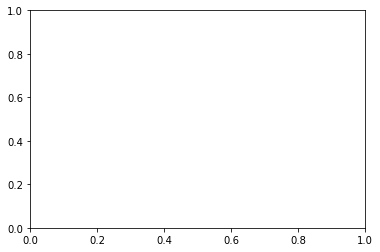

In [ ]:
def stripplot_matches(keywords, case=False):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

for celltype in celltypes:
    try:
        stripplot_matches(celltype)
    except:
        pass